# HGCAL FE studies

### imports and initial setup

In [2]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/CMS/hgcal/hgcal-analysis

from time import sleep
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly as py

from descartes import PolygonPatch
from tqdm import tqdm_notebook

import scripts.helpers as hlp
from skhep.modeling import bayesian_blocks


/home/naodell/work/CMS/hgcal/hgcal-analysis


### Convert data from root ntuples to dataframes

In [3]:
df = pd.read_pickle('data/single_gamma.pkl')
n_entries = df.ievt.unique().size

### Visualizations of detector hits, panels, and occupancies

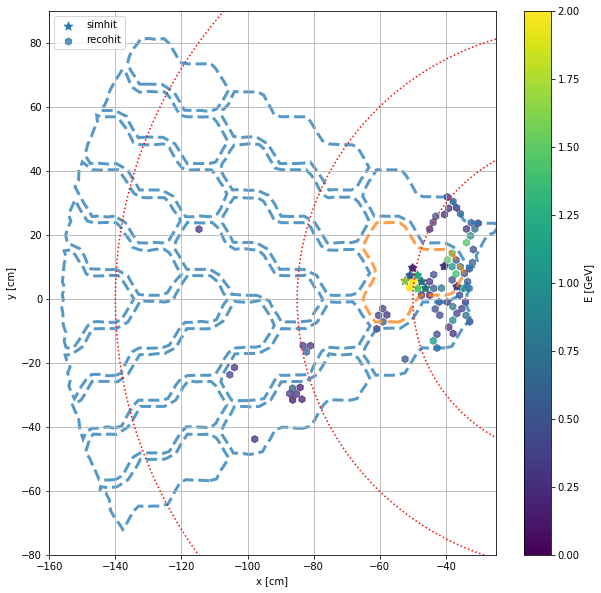

In [13]:
# get patches for module layouts
layer = 7
sector = 1
panel = 4
patch_file = open(f'data/panel_patches_zplus_{layer}.pkl', 'rb')
patches = pickle.load(patch_file)
patch_file.close()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')
for p, ashape in patches[sector].items():
    if p == panel:
        col = 'C1'
    else:
        col = 'C0'
    patch = PolygonPatch(ashape, fill=False, ec=col, linestyle='--', linewidth=3, label='_nolegend_', alpha=0.75)
    ax.add_patch(patch)

df_skim = df.query(f'subdet == 3 and zside == 1 and sector == 1 and layer == {layer}')
evt = df_skim.query(f'panel == {panel} and sim_e > 0').ievt.value_counts().index[0]
df_skim = df_skim.query(f'ievt == {evt}')
mask = df_skim.sim_e > 0

sim_scat  = ax.scatter(df_skim[mask].x, df_skim[mask].y, c=df_skim.sim_e[mask], 
                       cmap='viridis', 
                       marker='*', 
                       vmin=0.,
                       vmax=2.,
                       s=75, 
                       alpha=1.
                      )
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.reco_e, 
                       cmap='viridis', 
                       marker='h', 
                       vmin=0.,
                       vmax=2.,
                       s=50, 
                       alpha=0.75
                      )

ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
r = np.array([50, 85, 140])
phi = np.linspace(np.pi/2, 3*np.pi/2, 1000)
x, y = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 
ax.plot(x[0], y[0], 'r:', label='_nolegend_')
ax.plot(x[1], y[1], 'r:', label='_nolegend_')
ax.plot(x[2], y[2], 'r:', label='_nolegend_')

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='E [GeV]')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['simhit', 'recohit'])
plt.grid()

plt.savefig('plots/hits_test.png')
plt.show()

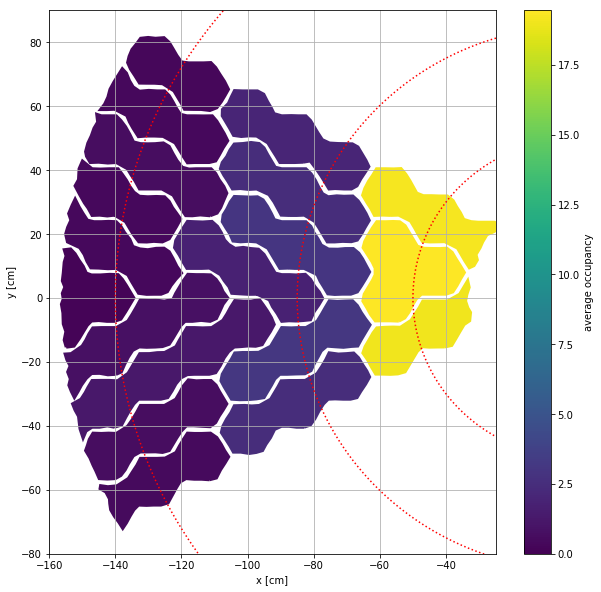

In [17]:
# sample occupancy plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

layer = 7
sector = 1
df_skim = df.query(f'subdet == 3 and zside == 1 and layer == {layer}')
s = df_skim.groupby('panel').sum()['zside']

# tmp hack
#centers = [( -45.996555,  26.552443), ( -85.601143,  49.418068), (-122.204628,  70.561249),
#           ( -52.309528,   8.186293), ( -85.023285,  32.505623), (-126.216042,  56.438793),
#           ( -83.052231,  14.980803), (-128.726608,  41.261883), ( -99.199333,   7.929051),
#           (-137.761444,  30.080639), ( -48.818104, -11.489166), ( -84.926186, -32.474018),
#           (-126.202728, -56.422054), ( -83.127579, -14.974498), (-128.724808, -41.280033),
#           (-123.665054, -21.916286), (-132.247528, -10.519128), (-139.554230,  14.877615),
#           (-149.350327,  -0.036200)
#          ]

for p, ashape in patches[sector].items():
    col = plt.cm.viridis(s.loc[p]/s.max())
    patch = PolygonPatch(ashape, fc=col, fill=True, ec=col, linestyle='-', linewidth=3, label='_nolegend_', alpha=1)
    extent = patch.get_extents().bounds
    ax.add_patch(patch)
    
    #c = centers[p-1]
    #ax.text(c[0], c[1], f'{p}')
    
ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

dummy = plt.scatter([0, 0], [0, 0], cmap='viridis', c=[0, s.max()/(6*n_entries)])
cbar = plt.colorbar(dummy, ax=ax, label='average occupancy')
cbar.set_alpha(1)
cbar.draw_all()

# draw some concentric circles
r = np.array([50, 85, 140])
phi = np.linspace(np.pi/2, 3*np.pi/2, 1000)
x, y = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 
ax.plot(x[0], y[0], 'r:', label='_nolegend_')
ax.plot(x[1], y[1], 'r:', label='_nolegend_')
ax.plot(x[2], y[2], 'r:', label='_nolegend_')

plt.grid()
plt.savefig('plots/panel_numbering_test.png')
plt.show()

I'm going to make a dictionary of events that can be mixed here.  The idea is that the detector will be symmetric in z and by sector w.r.t. the layout of the motherboards and the expected fluxes.  This symmetry can be leveraged so that characterizing panels in a single layer will be the same as characterizing another panel in the same layer, but in a different sector.  

In [18]:
# get events for making data mixtures:
df_skim = df.query('subdet == 3')
event_numbers = range(n_entries)
evt_dict = dict()
for z in tqdm_notebook([-1, 1], leave=False):
    df_z = df_skim.query(f'zside == {z}')
    layers = df_z.layer.unique()

    evt_dict[z] = dict()
    for l in tqdm_notebook(layers, leave=False):
        df_layer = df_z.query(f'layer == {l}')
        sectors = df_layer.sector.unique()

        evt_dict[z][l] = dict()
        for s in tqdm_notebook(sectors, leave=False):
            df_sector = df_layer.query(f'sector == {s}')
            panels = df_sector.panel.unique()

            evt_dict[z][l][s] = dict()
            for p in tqdm_notebook(panels, leave=False):
                df_panel    = df_sector.query(f'panel == {p}')
                sig_events = df_panel.query('sim_e > 0.').ievt.unique()
                bg_events  = np.array(list(set(event_numbers) - set(sig_events)))
                evt_dict[z][l][s][p] = (sig_events, bg_events)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [19]:
#loop over panels and layers
n_epochs = 100
layer = 5

df_dict = dict()
df_dict[layer] = dict()
for panel in tqdm_notebook(range(1, 19)):
    df_dict[layer][panel] = []
    for i in tqdm_notebook(range(n_epochs), leave=False):
        # randomly select z side and sector
        z = -1 if np.random.randint(2) == 0 else 1
        sectors = list(evt_dict[z][layer].keys())
        sector = np.random.choice(sectors)
        sig_events, bg_events = evt_dict[z][layer][sector][panel]
        if sig_events.size == 0: continue

        #print(z, sector, panel, sig_events.size)
        # get events
        df_skim = df.query(f'zside == {z} and layer == {layer} and sector == {sector} and panel =={panel}')
        sig_evt = int(np.random.choice(sig_events))
        df_sig = df_skim.query(f'ievt == {sig_evt}')

        bg_evts = np.random.choice(bg_events, size=7)
        df_bg = df_skim[df_skim.ievt.isin(bg_evts)]

        # apply tc selection algorithms here
        df_evt = pd.concat([df_sig, df_bg])
        df_evt = df_evt.sort_values('reco_e', ascending=False)
        e_min = df_evt.iloc[np.min([10, df_evt.shape[0]]) - 1]['reco_e']

        readout_mask = df_evt.reco_e > e_min
        df_evt['readout'] = readout_mask
        df_dict[layer][panel].append(df_evt.query('sim_e > 0.'))
    
    if len(df_dict[layer][panel]) > 0:
        df_dict[layer][panel] = pd.concat(df_dict[layer][panel])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [20]:
# calculate efficiencies and there errors
from scipy.stats import beta

effs = {}
bins = [0.01, 0.15, 0.3, 0.5, 1., 1.5, 2., 2.5, 3.2] 
for panel, df_panel in tqdm_notebook(df_dict[5].items()):
    #bins = bayesian_blocks(df_fraction.sim_e, p0=1e-6) 
    num, bins = np.histogram(df_panel.query('readout == True').sim_e, bins=bins)
    den, _ = np.histogram(df_panel.sim_e, bins=bins)
    dx = bins[1:] - bins[:-1]
    x = bins[:-1] + dx/2
    eff = num/den
    eff_ci = np.array([[beta.ppf(0.16, n, d - n + 1) if n > 0 else 0, beta.ppf(0.84, n+1, d - n) if n < d else 1] for n, d in zip(num, den)])
    eff_ci = eff_ci.transpose()
    
    effs[panel] = (eff, eff_ci)

A Jupyter Widget

/home/naodell/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:421: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(filename):
/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:608: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(fontprop):
/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1507: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not keywords[k](self.infoDict[k]):


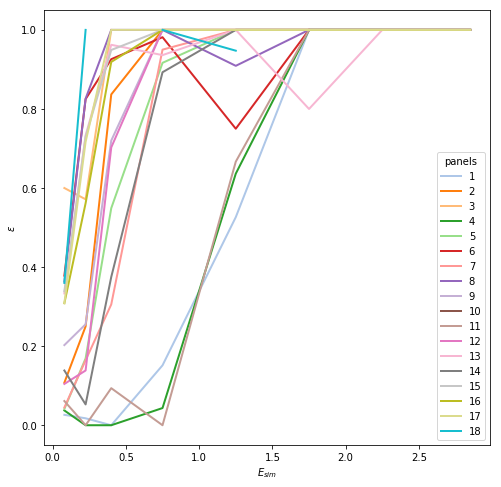

In [21]:
# plot the efficiencies
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n_panels = len(effs.keys())
for panel, e in effs.items():
    col = plt.cm.tab20(panel/19)
    ax.plot(x, e[0], c=col, label=f'{panel}', linewidth=2)
    #ax.fill_between(x, e[1][0], e[1][1],
    #                color=col,
    #                alpha=0.75,
    #                interpolate=False
    #               )

ax.set_xlabel(r'$E_{sim}$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(title='panels')

plt.savefig('plots/eff_vs_sime_all.pdf')
plt.show()

In [22]:
# calculate efficiencies and their errors
from scipy.stats import beta

bins = [0.01, 0.15, 0.3, 0.5, 1., 1.5, 2., 2.5, 3.2] 
flux_group = dict(inner = [1, 4, 11],  mid = [2, 5, 7, 9, 12, 14], outer = [3, 6, 8, 10, 13, 15, 16, 17, 18])
#flux_group = ['inner', 'mid', 'outer', 'inner', 'mid', 'outer', 'mid', 'outer', 'mid', 'outer', 'inner', 'mid', 'outer', 'mid', 'outer', 'outer', 'outer', 'outer', 'outer']
eff_data = dict()
for panel, df_panel in tqdm_notebook(df_dict[5].items()):
    #bins = bayesian_blocks(df_fraction.sim_e, p0=1e-6) 
    num, bins = np.histogram(df_panel.query('readout == True').sim_e, bins=bins)
    den, _ = np.histogram(df_panel.sim_e, bins=bins)
    eff_data[panel] = (num, den)
    
dx = bins[1:] - bins[:-1]
x = bins[:-1] + dx/2
effs = {}
for region, panels in flux_group.items():
    num = np.sum([eff_data[p][0] for p in panels], axis=0)
    den = np.sum([eff_data[p][1] for p in panels], axis=0)
    eff = num/den
    eff_ci = np.array([[beta.ppf(0.16, n, d - n + 1) if n > 0 else 0, beta.ppf(0.84, n+1, d - n) if n < d else 1] for n, d in zip(num, den)])
    eff_ci = eff_ci.transpose()
    
    effs[region] = (eff, eff_ci)

A Jupyter Widget

/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:421: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(filename):
/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:608: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(fontprop):
/home/naodell/opt/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1507: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not keywords[k](self.infoDict[k]):


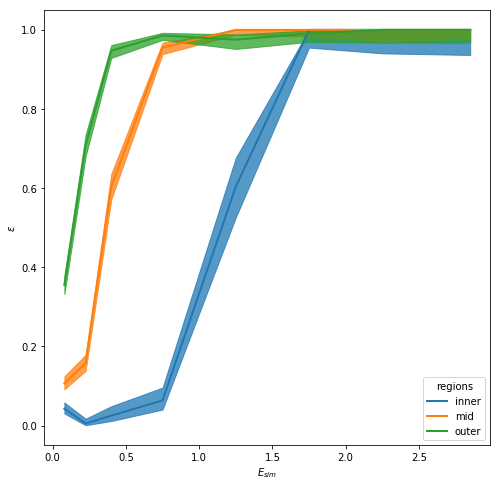

In [23]:
# plot the efficiencies
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n_panels = len(effs.keys())
for i, (panel, e) in enumerate(effs.items()):
    col = plt.cm.tab10(i)
    ax.plot(x, e[0], c = col, label=f'{panel}', linewidth=2)
    ax.fill_between(x, e[1][0], e[1][1],
                    color=col,
                    alpha=0.75,
                    interpolate=False
                   )

ax.set_xlabel(r'$E_{sim}$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(title='regions')

plt.savefig('plots/eff_vs_sime_region.pdf')
plt.show()

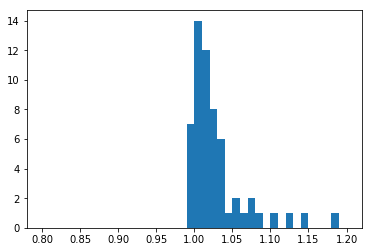

In [59]:
plt.figure(facecolor='white')
plt.hist(r, bins=40, range=(0.8, 1.2))
plt.show()